# Question-Answering with a Multi-Layer Bidirectional RNN

This notebook demonstrates how to build and train a **Multi-Layer Bidirectional Recurrent Neural Network (RNN)** to perform Question-Answering tasks over a Corpus of Documents.  (Themes include: Information Retrieval, NLP, Deep Learning)

**Question-Answering** consists in extracting precise and concise information (in the form of a short phrase or span of words) from a group of documents in order to answer a question. It involves a combination of **Document Retrieval** and **Natural Language Processing** techniques:
- **Step1:** Given the question, we retrieve the *k* most relevant documents from our Corpus. 
- **Step2:** We run a Text Comprehension model (our RNN) over the retrieved documents to extract the most satisfying answer in the form of a concise span of words.  

The key idea behind Question-Answering is to refuse to stop after Step1: **instead of letting the user go through all *k* documents and read through long paragraphs of text to find their answer, the model keeps going and finds it for them.**

![title](QANLP.png)


### Datasets & Resources

- **Training/Validation Set:** <a href="https://rajpurkar.github.io/SQuAD-explorer/" target="_blank">Ground-Truth Question-Answer triplets</a> extracted from the Stanford Question Answering Dataset (**SQuAD**) consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage
- **Embeddings:** <a href="xxx" target="_blank">xxx</a>
- **Research:**   
    * <a href="https://arxiv.org/pdf/1704.00051.pdf" target="_blank">**Reading Wikipedia to Answer Open-Domain Questions**</a> by Chen et Al (2017),
    * <a href="https://arxiv.org/pdf/1606.05250.pdf" target="_blank">**SQuAD original Research paper**</a>  by Rajpurkar et al (2016).


### Learning Objectives (Step 2: Text Comprehension): 

- Build a first simple RNN model in Keras/TensorFlow for Question-Answering 
- Build a Multi-Layer Bidirectional RNN in Keras/TensorFlow with and without Attention
- Evaluate the results on a test set
- Run the best performing model on our list of unanswered Covid-19 questions


## Before we start: Import Tensorflow & Other Tools

In [1]:
#!pip install -q annoy
#! pip install -q graphviz
#! pip install -q pydot

# Basics for Data Manipulation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 

# Tensorflow and Keras tools
import tensorflow as tf 
import tensorflow_hub as hub 

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Dense, Concatenate, Masking, Embedding, Dropout, Softmax, Dot, Lambda
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence 

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
import string


## First Overview of the Data

Our **Training QA dataset** consists in ground-truth question-context-answer triples extracted from the SQuAD Dataset:
* **question**: the question
* **context**: the document containing the answer
* **text**: the answer as a span of text
* **c_id**: the id of the context (some questions are asked on the same context)
* **start_word**: index of the first answer word in **context**
* **end_word**: index of the last answer word in **context**

Our model will input both the question and the context, and output the predicted start_word and end_word.

In [2]:
#Loading the data i.e. a dataframe 50,000 ground-truth question-context-answer triples from the SQuAD Dataset
data = pd.read_csv('utils/data/SquadLite50.csv') 
data.head(5)

,question,context,text,c_id,start_word,end_word
0,What number of Portuguese adults rated their h...,People are usually well informed about their h...,one third,18431,70,71
1,How many tons of toxic chemicals does GE relea...,GE has a history of some of its activities giv...,"2,000",6720,53,53
2,What caused mortgage lenders to relax underwri...,During a period of tough competition between m...,tough competition,18275,4,5
3,Where did the attack occur?,"On October 1, 1989, a peaceful demonstration o...",in front of Lviv's Druzhba Stadium,11471,18,23
4,Who led the group from San Diego that rescued ...,"In 1846, the United States went to war against...",Lieutenant Gray,16526,221,222


### Embedding & Prepping the data
**Embedding** consists in mapping words or phrases to vectors of real numbers. Conceptually it involves a mathematical projection from a space with many dimensions per word to a continuous vector space with a much lower dimension. Here, we can use the <a href="https://tfhub.dev/google/nnlm-en-dim128/2" target="_blank">NNLM text embedding module</a> from TF-Hub, a 128-d embedding built from the English Google News 200B corpus.

**Padding** (a special form of masking) is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data. This is particularly useful when we want to use the same model with input data of different lengths: it will be crucial here as questions and paragraphs do not all have the same number of words in them.

In [33]:
# Splitting the questions/paragraphs into words and embedding them...
pars = []
ques = []
embed = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2") #NNLM

for text in data.context:
    words = np.array(text_to_word_sequence(text))
    pars.append(embed(tf.constant(words)))
for text in data.question:
    words = np.array(text_to_word_sequence(text))
    ques.append(embed(tf.constant(words)))

In [34]:
# Now padding...
padded_pars = tf.keras.preprocessing.sequence.pad_sequences(pars, padding="post",dtype='float32')
padded_ques = tf.keras.preprocessing.sequence.pad_sequences(ques, padding="post",dtype='float32')

In [35]:
np.save('utils/data/pars_NNLM50.npy', padded_pars) 
np.save('utils/data/ques_NNLM50.npy', padded_ques) 

In [3]:
padded_pars = np.load('utils/data/pars_NNLM50.npy')
padded_ques = np.load('utils/data/ques_NNLM50.npy')

In [4]:
# Key Dimensions
batchSize = np.shape(padded_pars)[0] #BatchSize
seq_pars = np.shape(padded_pars)[1] #TimeSteps
seq_ques = np.shape(padded_ques)[1] #TimeSteps
emb_dim = np.shape(padded_pars)[2] #Embed Dimension

print("Shape of the Padded Embedded Paragraphs: ", np.shape(padded_pars))
print("Shape of the Padded Embedded Questions: ", np.shape(padded_ques))
print("i.e. (Batch Size, Sequence Length, Embed Dimension)")

# Our y vector
y = data[['question','context','text','start_word', 'end_word']]

Shape of the Padded Embedded Paragraphs:  (50000, 675, 128)
Shape of the Padded Embedded Questions:  (50000, 37, 128)
i.e. (Batch Size, Sequence Length, Embed Dimension)


Now we split our data into a **train set** and a **test set**. The model will be initially fit on the **training set** (with use of a validation set), and we'll test our final results on the test set.

In [5]:
# Train & Test Sets
# Using random_state to be able to reproduce results

p_train, p_test, q_train, q_test, y_train, y_test = train_test_split(padded_pars, padded_ques, y, 
                                                                     test_size=0.2, random_state=30)

# Start & End Words
ys_train = np.array(y_train.start_word)
ys_test = np.array(y_test.start_word)

ye_train = np.array(y_train.end_word)
ye_test = np.array(y_test.start_word)

## Metrics and Evaluation
Let's define our **evaluation metrics** right away (for more details, see the  <a href="https://arxiv.org/pdf/1606.05250.pdf" target="_blank">SQuAD original Research paper</a>  by Rajpurkar & al.): 
* **Exact Match**: This metric measures the percentage of predictions that match the ground truth answers exactly.
* **F1 Score**: This metric measures the average overlap between the prediction and ground truth answer, by computing their F1 (a function of precision and recall):  
    * **P = Precision** = the number of *true positives* divided by the total of *predicted positives* = tp /(tp+fp). In our case here, this is the number of words appearing in both prediction and ground truth answer, divided by the total number of words in the *prediction*.
    * **R = Recall** = the number of *true positives* divided by the total of *actual positives* = tp/(tp+fn). In our case here, this is the number of words appearing in both prediction and ground truth answer, divided by the total number of words in the *ground truth answer*.
    * **F1 Score** = 2PR/(P + R)

For reference, in <a href="https://arxiv.org/pdf/1704.00051.pdf" target="_blank">Reading Wikipedia to Answer Open-Domain Questions</a> (2017), Chen et Al managed to obtain a **70.7% EM Score** and a **79.4% F1 Score** on the SQuAD Leaderboard with their most finely-tuned model (using a dataset of 100,000+ datapoints).

In [6]:
# Let's create functions to measure these metrics
# Both take strings as inputs

def exact_match(pred, truth):
    truth = str(truth).replace("-", " ")
    truth = "".join(l for l in truth if l not in string.punctuation)
    return np.sum(str(pred).lower() == str(truth).lower())

def F1_score(pred, truth):
    p = text_to_word_sequence(str(pred))
    t = text_to_word_sequence(str(truth))
    tp = [i for i in p if i in t]
    if len(tp) == 0:
        F1 = 0
    else:
        precision = len(tp)/len(p)
        recall = len(tp)/len(t)   
        F1 = 2 * (precision * recall) / (precision + recall)
    return F1

## What's a Recurrent Neural Network (RNN)?
A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. They are particularly useful to solve NLP problems: in a sentence or phrase, the sequence of words is just as important - if not more - as the individual words themselves.
  
There are built-in RNN layers in Keras, ready to use to quickly build recurrent models without having to make difficult configuration choices:
* keras.layers.**SimpleRNN**, a basic fully-connected RNN,
* keras.layers.**LSTM**, first proposed in Hochreiter & Schmidhuber 1997 to address the *Vanishing Gradient* problem,  
* keras.layers.**GRU**, first proposed in Cho et al. 2014 as a simplified version of LSTM,

You can check the <a href="https://keras.io/api/layers/recurrent_layers/" target="_blank">RNN API documentation</a> for more information, or go through the <a href="https://www.tensorflow.org/guide/keras/rnn" target="_blank">TensorFlow guide on RNN</a> for simple examples and setups.  
Also check out <a href="http://proceedings.mlr.press/v37/jozefowicz15.pdf" target="_blank">**An Empirical Exploration of Recurrent Network Architectures**</a> by Jozefowicz et al. for more details about the differences between GRU and LSTM.




![title](FirstModel.png)  

This first model will be the foundation for all our following models. We have:
* **Pre-Embedded Input**: paragraph p and question q both pre-embedded with NNLM - we just did that! Yay!
* **GRU Layers**: straightforward GRU layers, one for p and one for q 
* **Weighthed Average for q'**: to obtain a single vector q' - the A weight vector within the Softmax will be learned
* **Bilinear Similarity Layer on p' and q'**: to obtain start and end probabilities (this will give us the answer span) - we can obtain this with using a Dense layer (with a 'linear' activation function) followed by a Dot product 


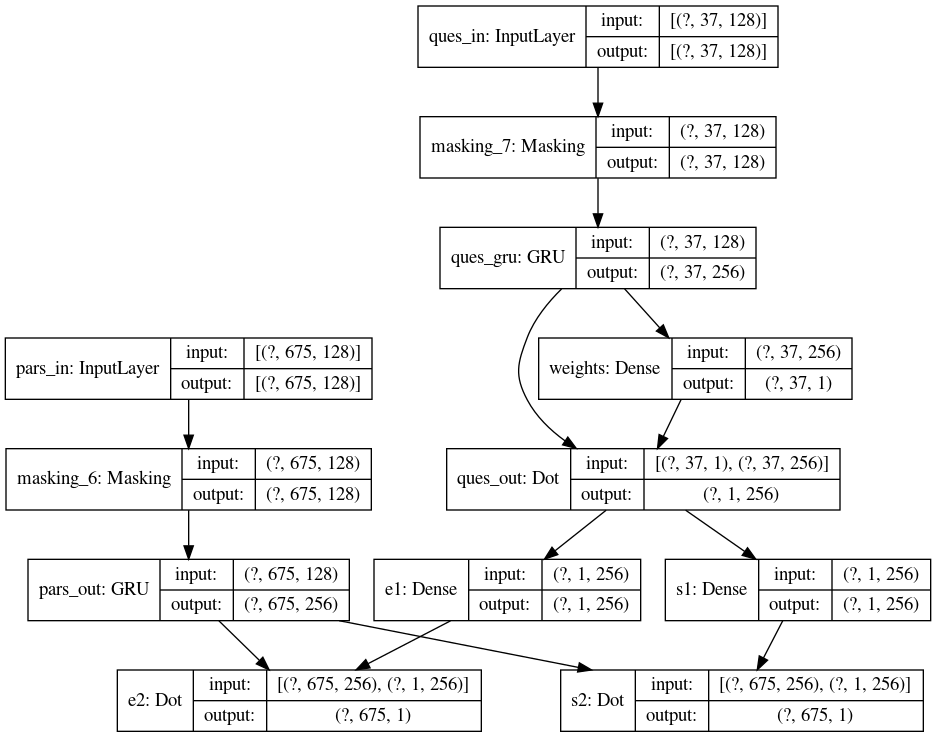

In [27]:
# First Input = Paragraphs / Straightforward GRU Layer
paragraphs = Input(shape=(seq_pars,emb_dim), name = "pars_in")
p = Masking(mask_value=0)(paragraphs)
p = GRU(256, return_sequences=True, name = "pars_out")(p)
# Output is = a 128d vector per word in the paragraph (None, seq_pars, 128).

# Second Input = Questions / Straightforward GRU 
questions = Input(shape=(seq_ques,emb_dim), name = "ques_in")
q = Masking(mask_value=0)(questions)
q = GRU(256, return_sequences=True, name = "ques_gru")(q)
# Output is = a 256d vector per word in the paragraph (None, seq_ques, 256).

# Weighted Average to obtain the single vector q'
weights = Dense(1, activation='softmax', name = "weights")(q)
q = Dot(axes=1, name = "ques_out")([weights,q])
# Output is = a single 256d vector per question (None, 256, 1).

# Outputs for Start & End / Quadratic Layers and Softmax
qs = Dense(256, activation = 'linear', name = "s1", use_bias=False, kernel_regularizer=regularizers.l2(0.001))(q)
outs = Dot(axes=(2, 2), name = "s2")([p, qs])
#outs = Softmax(axis=1, name = "start")(outs)

qe = Dense(256, activation = 'linear', name = "e1", use_bias=False, kernel_regularizer=regularizers.l2(0.001))(q)
oute = Dot(axes=(2, 2), name = "e2")([p, qe])
#oute = Softmax(axis=1, name = "end")(oute)
# Output is = a probability vector (None, seq_pars, 1) for each

# Model
BaseModel = Model(inputs=[paragraphs, questions], outputs=[outs, oute])
# print(BaseModel.summary())

# Model Chart
plot_model(BaseModel, to_file='Baseline.png', show_shapes = True)

    

Let's now compile and train our model, using **Sparce Categorical Cross-Entropy Loss** as our loss function (you can read more about it <a href="https://cwiki.apache.org/confluence/display/MXNET/Multi-hot+Sparse+Categorical+Cross-entropy#:~:text=Categorical%20Cross%20Entropy-,Definition,only%20belong%20to%20one%20class." target="_blank">**here**</a>) and **Sparse Categorical Accuracy** as our key metric.

In [8]:
# Compiling
top = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top") #'sparse_top_k_categorical_accuracy'

opt = tf.keras.optimizers.Adam()  #learning_rate=0.02

sce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="SCEloss")

BaseModel.compile(optimizer=opt, 
                  loss= [sce, sce],  #['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
                  loss_weights = [1,1],
                  metrics = [[top],[top]]) 

In [9]:
# Defining a checkpoint to save our best model during Training
checkpoint = ModelCheckpoint(filepath = 'utils/model',
                            frequency = "epoch", 
                            save_weights_only = True,
                            save_best_only = True,
                            #monitor = "val_e2_s2_top",   #default will save based on the optimal val_loss
                            #mode='max',
                            verbose = 0)

In [11]:
# Training
history = BaseModel.fit([p_train, q_train], [ys_train, ye_train],
                        validation_split = 0.1,
                        epochs = 8,
                        batch_size = 64,
                        callbacks = [checkpoint],
                        verbose = 1)

563/563 [==============================] - 4055s 7s/step - loss: 6.5780 - s2_loss: 3.0033 - e2_loss: 3.0128 - e2_s2_top: 0.2416 - val_loss: 7.4205 - val_s2_loss: 3.4491 - val_e2_loss: 3.4252 - val_e2_s2_top: 0.1881


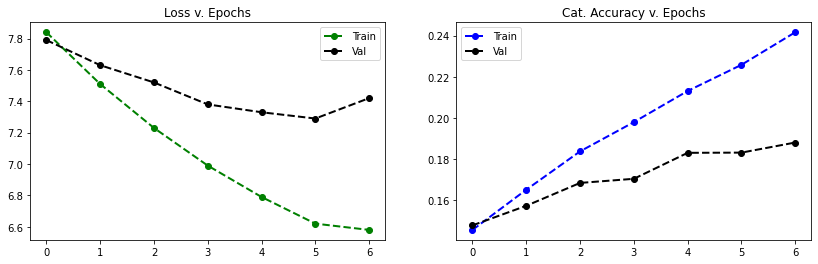

In [12]:
#Plotting Training Loss and Accuracy
#hist = history.history
hist = {}
hist['loss'] = [7.84, 7.51, 7.23, 6.99, 6.79, 6.62, 6.58]
hist['val_loss'] = [7.79, 7.63, 7.52, 7.38, 7.33, 7.29, 7.42]
hist['e2_s2_top'] = [0.1457, 0.1652, 0.1838, 0.1980, 0.2131, 0.2258, 0.2416]
hist['val_e2_s2_top'] = [0.1479, 0.1574, 0.1685, 0.1705, 0.1831, 0.1832, 0.1881]



def plot_hist(hist):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    ax[0].plot(hist['loss'], color='green', marker='o', linestyle='dashed',linewidth=2, markersize=6, label='Train')
    ax[0].plot(hist['val_loss'], color='black', marker='o', linestyle='dashed',linewidth=2, markersize=6, label='Val')
    ax[0].set_title('Loss v. Epochs')
    ax[0].legend()
    
    ax[1].plot(hist['e2_s2_top'], color='blue', marker='o', linestyle='dashed',linewidth=2, markersize=6, label='Train')
    ax[1].plot(hist['val_e2_s2_top'], color='black', marker='o', linestyle='dashed',linewidth=2, markersize=6, label='Val')
    ax[1].set_title('Cat. Accuracy v. Epochs')
    ax[1].legend()
    plt.show()

plot_hist(hist)

In [10]:
# Using our Best Model only i.e. load the saved weights
# BaseModel.save_weights('utils/model')
BaseModel.load_weights('utils/model')

In [13]:
# Evaluating our Model on the Test Dataset
ev = BaseModel.evaluate([p_test, q_test], [ys_test, ye_test], verbose =2)

313/313 - 359s - loss: 8.2129 - s2_loss: 3.5167 - e2_loss: 4.1499 - e2_s2_top: 0.1397


In [23]:
p = tf.expand_dims(padded_pars[5],0)
q = tf.expand_dims(padded_ques[5],0)


BaseModel([p, q])

[<tf.Tensor: shape=(1, 675, 1), dtype=float32, numpy=
 array([[[11.451852 ],
         [ 9.67292  ],
         [10.661413 ],
         [11.340269 ],
         [10.762928 ],
         [11.032307 ],
         [10.267291 ],
         [11.605587 ],
         [10.853173 ],
         [10.557779 ],
         [11.935667 ],
         [11.478306 ],
         [11.050289 ],
         [12.476868 ],
         [11.77758  ],
         [13.492553 ],
         [13.491777 ],
         [14.038137 ],
         [12.045789 ],
         [11.17199  ],
         [12.0730915],
         [12.370004 ],
         [12.453829 ],
         [13.111065 ],
         [11.896986 ],
         [10.490628 ],
         [ 9.838156 ],
         [ 9.175314 ],
         [10.006304 ],
         [11.443638 ],
         [11.377174 ],
         [12.072416 ],
         [11.531527 ],
         [10.815615 ],
         [11.793787 ],
         [11.334143 ],
         [10.633066 ],
         [11.162273 ],
         [10.783752 ],
         [10.654425 ],
         [ 9.3027525],
   

In [56]:
BaseModel.save('utils/model_best')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: utils/model_best/assets


### Evaluation in terms of EM and F1 Scores
We want to evaluate our model in terms of EM and F1 Score. The function below extracts the predicted spans, computes the EM and F1 scores on each datapoint, and returns an average.   

In [21]:
base_pred_test = BaseModel.predict([p_test,q_test])
#base_pred_train = BaseModel.predict([p_train,q_train])

In [22]:
# Function to measure overall EM and F1
def model_eval(pred, test = True):
    s = tf.exp(pred[0])
    e = tf.exp(pred[1])

    m = tf.matmul(s, tf.transpose(e, [0, 2, 1]))
    i, j = np.meshgrid(*map(np.arange, (m.shape[1],m.shape[2])), indexing='ij')
    m.mask = (i <= j) & (j < i+16 )
    m = np.where(m.mask, m, 0)
    o = np.amax(m, axis= (1,2))

    em = []
    f1 = []
    
    if test:
        y = y_test.reset_index()
    else: y = y_train.reset_index()
    
    for k in range(m.shape[0]):
        result = np.where(m[k] == o[k])
        answer = np.array(text_to_word_sequence(y.context[k]))[result[0][0]:result[1][0]+1]

        if result[0][0] != result[1][0]: 
            answer = " ".join(answer)
        else: answer = str(answer[0])
        em.append(exact_match(answer, y.text[k]))
        f1.append(F1_score(answer, y.text[k]))

    EM = np.mean(em)
    F1 = np.mean(f1)
    
    print("Exact Match: ", np.round(EM,3))
    print("F1 Score: ", np.round(F1,3))
           
    return (EM,F1)

In [23]:
print("**Results on Test Set:")
(EM,F1) = model_eval(base_pred_test, test=True)

**Results on Test Set:
Exact Match:  0.136
F1 Score:  0.293


In [18]:
print("**Results on Train Set:")
(EM,F1) = model_eval(base_pred_train, test=False)

**Results on Train Set:
Exact Match:  0.179
F1 Score:  0.372


Our Base Model obtains an **Exact Match Score of 9.2%**, and a **F1 Score of 22.6%.**  
Not too impressive yet! Let's see how we can improve from there!



![title](ImproveModel.png) 


We can improve the model in different ways:
* **Adding Layers**: The main reason for stacking layers is to allow for greater model complexity - which is exactly what we're looking for here!  
* **Bi-directionality**: A key idea of RNNs is to take in a sequence from left (past) to right (future) and preserve information from one word to the next. Conceptually, this implies each word is treated in the context of the words that came before it. But context is not unidirectional: using bi-directionality will allow the model to run from left to right and from right to left: it will preserve information from both past and future, and will be able to treat a word in its *full* context. You can read more about it <a href="https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks" target="_blank">here</a>.  
* **Adding features to *pi***:
    * **Binary Features**: takes the value 1 if *pi* is an exact match with any one of the words in ***q***, 0 otherwise. We could also look at lemmas or NERs, and match them with the lemmas or NERs in ***q***, but we will keep it simple here.
    * **Attention-like Feature**: a weighted average of the question embeddings *qj* (with weights defined as the attention scores with *pi* - for simplification here, we'll use a softmax of the inner product). You can read more about Attention in these <a href="http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes06-NMT_seq2seq_attention.pdf" target="_blank">NLP notes from Stanford</a>.  

    

### Adding features and Attention

In [27]:
# Adding the Binary Features
binary = []
for i in range(padded_pars.shape[0]):
    words_pars = text_to_word_sequence(data.context[i])
    words_ques = text_to_word_sequence(data.question[i])
    c = [1 if w in words_ques else 0 for w in words_pars]
    binary.append(c)

binary_features = tf.keras.preprocessing.sequence.pad_sequences(binary, padding="post",dtype='float32') 
binary_features = tf.expand_dims(binary_features,2)


In [28]:
# Adding the Attention-like Feature
attention = tf.einsum('aij,ajk->aik', 
                      padded_pars, 
                      tf.transpose(padded_ques, perm=[0, 2, 1])) #Pair-wise dot products (Attention scores)

norm = tf.where(tf.reduce_sum(attention, axis = 2) == 0, 
                1, tf.reduce_sum(attention, axis = 2)) 

norm = tf.broadcast_to(tf.expand_dims(norm,2), attention.shape)

attention_features = tf.einsum('aij,ajk->aik', attention/norm, padded_ques) #Attention-like Features

In [29]:
# Concatenate into new dataset
padded_pars_extra = tf.concat([padded_pars, attention_features, binary_features],2)

In [30]:
np.save('utils/data/pars_NNLM50_extra.npy', padded_pars_extra) 

In [31]:
# Updating Key Dimensions and new train/test sets (with same random state for consistency)

emb_dim_extra = np.shape(padded_pars_extra)[2] #Embed Dimension
print("Shape of the new Paragraphs: ", np.shape(padded_pars_extra))

p_train_extra, p_test_extra = train_test_split(padded_pars_extra, test_size=0.2, random_state=30)

Shape of the new Paragraphs:  (50000, 675, 257)


### Making our model Multi-Layer & Bi-directional

In [ ]:
# First Input = Paragraphs / Straightforward GRU Layer
paragraphs = Input(shape=(seq_pars,emb_dim_extra), name = "pars_in")
p = Masking(mask_value=0)(paragraphs)
# p = GRU(256, return_sequences=True, name = "pars_out")(p)
p = Bidirectional(GRU(128, return_sequences=True, name = "pars_out",kernel_regularizer=regularizers.l2(0.0015)), merge_mode = 'concat')(p)
p = Bidirectional(GRU(128, return_sequences=True, name = "pars_out",kernel_regularizer=regularizers.l2(0.0015)), merge_mode = 'concat')(p)
p = Bidirectional(GRU(64, return_sequences=True, name = "pars_out", kernel_regularizer=regularizers.l2(0.0015)), merge_mode = 'concat')(p)
# Output is = a 128d vector per word in the paragraph (None, seq_pars, 128).

# Second Input = Questions / Straightforward GRU 
questions = Input(shape=(seq_ques,emb_dim_extra), name = "ques_in")
q = Masking(mask_value=0)(questions)
q = GRU(256, return_sequences=True, name = "ques_gru")(q)
# Output is = a 256d vector per word in the paragraph (None, seq_ques, 256).

# Weighted Average to obtain the single vector q'
weights = Dense(1, activation='softmax', name = "weights")(q)
q = Dot(axes=1, name = "ques_out")([weights,q])
# Output is = a single 256d vector per question (None, 256, 1).

# Outputs for Start & End / Quadratic Layers and Softmax
qs = Dense(128, activation = 'linear', name = "s1", use_bias=False, kernel_regularizer=regularizers.l2(0.0015))(q)
outs = Dot(axes=(2, 2), name = "s2")([p, qs])
#outs = Softmax(axis=1, name = "start")(outs)

qe = Dense(128, activation = 'linear', name = "e1", use_bias=False, kernel_regularizer=regularizers.l2(0.0015))(q)
oute = Dot(axes=(2, 2), name = "e2")([p, qe])
#oute = Softmax(axis=1, name = "end")(oute)
# Output is = a probability vector (None, seq_pars, 1) for each

# Model
ComplexModel = Model(inputs=[paragraphs, questions], outputs=[outs, oute])
# print(BaseModel.summary())

# Model Chart
# plot_model(BaseModel, to_file='Complex.png', show_shapes = True)


In [ ]:
# Compiling
top = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top") #'sparse_top_k_categorical_accuracy'

opt = tf.keras.optimizers.Adam()  #learning_rate=0.02

sce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="SCEloss")

ComplexModel.compile(optimizer=opt, 
                  loss= [sce, sce],  #['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
                  loss_weights = [1,1],
                  metrics = [[top],[top]]) 

In [ ]:
# Defining a checkpoint to save our best model during Training
checkpoint = ModelCheckpoint(filepath = 'utils/complexmodel',
                            frequency = "epoch", 
                            save_weights_only = True,
                            save_best_only = True,
                            #monitor = "val_e2_s2_top",   #default will save based on the optimal val_loss
                            #mode='max',
                            verbose = 0)

In [ ]:
# Training
history = ComplexModel.fit([p_train, q_train], [ys_train, ye_train],
                        validation_split = 0.1,
                        epochs = 6,
                        batch_size = 64,
                        callbacks = [checkpoint],
                        verbose = 1)

In [ ]:
# Evaluating our Model on the Test Dataset
ev = ComplexModel.evaluate([p_test, q_test], [ys_test, ye_test], verbose =2)

In [ ]:
pred_test = ComplexModel.predict([p_test,q_test])
print("**Results on Test Set:")
(EM,F1) = model_eval(pred_test, test=True)

## Let's explore our Results!
Let's define a function that will allow us to **explore the performance of our model**: the function will take the index of a datapoint in our set, and return the question, context and ground-truth answer, as well as our model's answer and its EM/F1 scores for this particular example.

In [14]:
# Function to get the result on the kth question
def get_result(k, model = FinalModel, verbose=True):
    
    p = tf.expand_dims(padded_pars[k],0)
    q = tf.expand_dims(padded_ques[k],0)
    out = model([p, q])
    start = tf.exp(out[0][0])
    end = tf.exp(out[1][0])
    
    
    #print(np.where(start == np.amax(start)))
    #print(np.where(end == np.amax(end)))
    
    m = tf.matmul(start, tf.transpose(end))
    i, j = np.meshgrid(*map(np.arange, m.shape), indexing='ij')
    m.mask = (i <= j) & (j < i+16 )
    m = np.where(m.mask, m, 0)
    result = np.where(m == np.amax(m)) #np.partition(m.flatten(), -2)[-10])
    
    #print(result)
    #print(np.amax(m))
    
    answer = np.array(text_to_word_sequence(data.context[k]))[result[0][0]:result[1][0]+1]
    if result[0][0] != result[1][0]: 
        answer = " ".join(answer)
    else: answer = str(answer[0])
        
    if k in y_train.index:
        print("Example from the Training Set")
    else: print("Example from the Test Set")
    
    if verbose:
        print("--------------------------------------------------------")   
        print("Question: ", data.question[k])
        print("--------------------------------------------------------") 
        print("Context: ")
        print(data.context[k])
    print("--------------------------------------------------------") 
    print("Model's answer: ", answer)
    print("Correct answer was: ", data.text[k])
    print("Start: ", data.start_word[k])
    print("Start: ", data.end_word[k])
    print("--------------------------------------------------------") 
    print("EM Score: ", exact_match(answer, data.text[k]))
    print("F1 Score: ", np.round(F1_score(answer, data.text[k]),3))
    

We can now have fun and play with our model a little bit:
* example 35 and 55 (correct) / Test
* example 5 and 30 (correct but missing a 'the') / Test & Train
* example 1 (no diff between tons and pounds) / Train 
* example 2 (just false) / Test 

Admittedly, while results are sometimes spot-on, we of course still see some wrong answers...! 

In [30]:
# Try some examples!
get_result(35)
print(25*"-- ")
get_result(55)
print(25*"-- ")
get_result(1)

Example from the Test Set
--------------------------------------------------------
Question:  Pedro II was the Emperor of what Country?
--------------------------------------------------------
Context: 
Bell began a series of public demonstrations and lectures to introduce the new invention to the scientific community as well as the general public. A short time later, his demonstration of an early telephone prototype at the 1876 Centennial Exposition in Philadelphia brought the telephone to international attention. Influential visitors to the exhibition included Emperor Pedro II of Brazil. Later Bell had the opportunity to demonstrate the invention personally to Sir William Thomson (later, Lord Kelvin), a renowned Scottish scientist, as well as to Queen Victoria, who had requested a private audience at Osborne House, her Isle of Wight home. She called the demonstration "most extraordinary". The enthusiasm surrounding Bell's public displays laid the groundwork for universal acceptance o

## Final Evaluation & Next Steps

Results are: xxx  

What could we do now to improve our model even further: more data, tweaking hyper-parameters, trainable embeddings (or more adapted ones), etc.  

To think about: What if we wanted to also plan for cases where the answer is *not* in the given paragraph? How would we set up the model then? 

